<a href="https://colab.research.google.com/github/panditamey1/Stock-Prediction-using-different-models/blob/main/stock_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an LSTM model to predict the price of the S&P 500

- LSTM stands for Long Short Term Memory

The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased. 

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br>
<b>To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.</b>

## Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
# Read in data
spy = pd.read_csv('ticker_20MICRONS.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

In [ ]:
def split_data(filename):
  spy = pd.read_csv(filename)

  # Convert series into datetime type
  spy['Date'] = pd.to_datetime(spy['Date'])

  # Save target series
  series = spy['Close']
    
  # Create train data set
  train_split_date = spy.iloc[int(0.7*len(spy))]['Date']
  train_split_index = np.where(spy.Date == train_split_date)[0][0]
  x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

  # Create test data set
  test_split_date = spy.iloc[int(0.8*len(spy))]['Date']
  test_split_index = np.where(spy.Date == test_split_date)[0][0]
  x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

  # Create valid data set
  valid_split_index = (train_split_index.max(),test_split_index.min())
  x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

  # Reshape values
  x_train_values = x_train.values.reshape(-1, 1)
  x_valid_values = x_valid.values.reshape(-1, 1)
  x_test_values = x_test.values.reshape(-1, 1)

  #  Create Scaler Object
  x_train_scaler = MinMaxScaler(feature_range=(0, 1))

  # Fit x_train values
  normalized_x_train = x_train_scaler.fit_transform(x_train_values)

  # Fit x_valid values
  normalized_x_valid = x_train_scaler.transform(x_valid_values)

  # Fit x_test values
  normalized_x_test = x_train_scaler.transform(x_test_values)

  # All values normalized to training data
  spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))
  return normalized_x_train, normalized_x_valid, normalized_x_test, x_train_scaler, x_test_values

In [ ]:
print(len(spy))
0.2*len(spy)
train_split_date  = spy.iloc[int(0.7*len(spy))]['Date']
np.where(spy.Date == train_split_date)[0][0]
# print(spy[int(0.7*len(spy)):int(0.8*len(spy))].shape)
# print(spy[int(0.8*len(spy)):].shape)
train_split_date  = spy.iloc[int(0.8*len(spy))]['Date']
np.where(spy.Date == train_split_date)[0][0]

3487


2789

In [ ]:




# Create train data set
train_split_date = spy.iloc[int(0.7*len(spy))]['Date']
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = spy.iloc[int(0.8*len(spy))]['Date']
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

2440 2441 2788 2789 3486


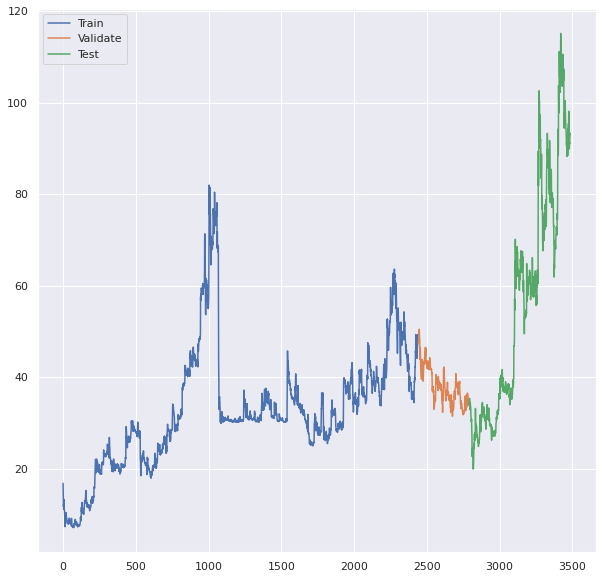

In [ ]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [ ]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [ ]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


122/122 [==============================] - 9s 11ms/step - loss: 0.0553 - mae: 0.2962 - lr: 1.0000e-05
Epoch 2/100
122/122 [==============================] - 1s 9ms/step - loss: 0.0283 - mae: 0.2053 - lr: 1.1220e-05
Epoch 3/100
122/122 [==============================] - 1s 9ms/step - loss: 0.0077 - mae: 0.0947 - lr: 1.2589e-05
Epoch 4/100
122/122 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0419 - lr: 1.4125e-05
Epoch 5/100
122/122 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0427 - lr: 1.5849e-05
Epoch 6/100
122/122 [==============================] - 1s 9ms/step - loss: 0.0017 - mae: 0.0407 - lr: 1.7783e-05
Epoch 7/100
122/122 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0384 - lr: 1.9953e-05
Epoch 8/100
122/122 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0361 - lr: 2.2387e-05
Epoch 9/100
122/122 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0340 - lr: 2.511

(1e-08, 1.0, 0.0, 0.01)

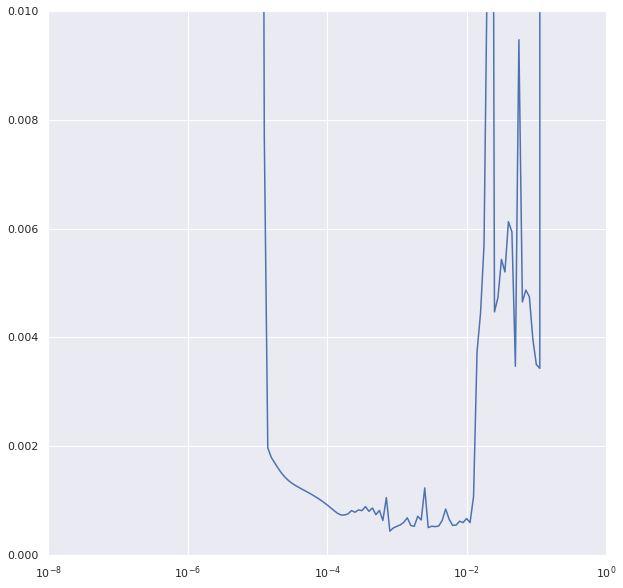

In [ ]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

## Build and Train LSTM Model

In [ ]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-3)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     78/Unknown - 4s 9ms/step - loss: 0.0025 - mae: 0.0410

81/81 [==============================] - 12s 111ms/step - loss: 0.0024 - mae: 0.0410 - val_loss: 6.4070e-04 - val_mae: 0.0299
Epoch 2/500
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0306

81/81 [==============================] - 7s 93ms/step - loss: 0.0011 - mae: 0.0309 - val_loss: 5.2447e-04 - val_mae: 0.0272
Epoch 3/500
79/81 [============================>.] - ETA: 0s - loss: 8.2590e-04 - mae: 0.0252

81/81 [==============================] - 7s 89ms/step - loss: 8.2893e-04 - mae: 0.0255 - val_loss: 4.9075e-04 - val_mae: 0.0265
Epoch 4/500
79/81 [============================>.] - ETA: 0s - loss: 7.4119e-04 - mae: 0.0232

81/81 [==============================] - 8s 95ms/step - loss: 7.4458e-04 - mae: 0.0235 - val_loss: 4.6301e-04 - val_mae: 0.0259
Epoch 5/500
78/81 [===========================>..] - ETA: 0s - loss: 6.3618e-04 - mae: 0.0212

81/81 [==============================] - 7s 93ms/step - loss: 6.4036e-04 - mae: 0.0216 - val_loss: 4.4198e-04 - val_mae: 0.0253
Epoch 6/500
78/81 [===========================>..] - ETA: 0s - loss: 5.9995e-04 - mae: 0.0203

81/81 [==============================] - 9s 112ms/step - loss: 6.0376e-04 - mae: 0.0207 - val_loss: 4.1724e-04 - val_mae: 0.0246
Epoch 7/500
79/81 [============================>.] - ETA: 0s - loss: 5.4898e-04 - mae: 0.0194

81/81 [==============================] - 7s 93ms/step - loss: 5.5298e-04 - mae: 0.0197 - val_loss: 3.9402e-04 - val_mae: 0.0240
Epoch 8/500
77/81 [===========================>..] - ETA: 0s - loss: 5.1875e-04 - mae: 0.0185

81/81 [==============================] - 7s 93ms/step - loss: 5.2437e-04 - mae: 0.0190 - val_loss: 3.6967e-04 - val_mae: 0.0233
Epoch 9/500
78/81 [===========================>..] - ETA: 0s - loss: 4.8793e-04 - mae: 0.0180

81/81 [==============================] - 8s 94ms/step - loss: 4.9139e-04 - mae: 0.0183 - val_loss: 3.4640e-04 - val_mae: 0.0225
Epoch 10/500
81/81 [==============================] - ETA: 0s - loss: 4.6701e-04 - mae: 0.0178

81/81 [==============================] - 8s 95ms/step - loss: 4.6701e-04 - mae: 0.0178 - val_loss: 3.2352e-04 - val_mae: 0.0217
Epoch 11/500
78/81 [===========================>..] - ETA: 0s - loss: 4.3943e-04 - mae: 0.0169

81/81 [==============================] - 7s 89ms/step - loss: 4.4212e-04 - mae: 0.0173 - val_loss: 3.0202e-04 - val_mae: 0.0209
Epoch 12/500
79/81 [============================>.] - ETA: 0s - loss: 4.1950e-04 - mae: 0.0166

81/81 [==============================] - 8s 95ms/step - loss: 4.2163e-04 - mae: 0.0168 - val_loss: 2.8181e-04 - val_mae: 0.0201
Epoch 13/500
80/81 [============================>.] - ETA: 0s - loss: 3.9963e-04 - mae: 0.0163

81/81 [==============================] - 8s 94ms/step - loss: 4.0167e-04 - mae: 0.0164 - val_loss: 2.6333e-04 - val_mae: 0.0194
Epoch 14/500
78/81 [===========================>..] - ETA: 0s - loss: 3.8258e-04 - mae: 0.0157

81/81 [==============================] - 7s 94ms/step - loss: 3.8432e-04 - mae: 0.0160 - val_loss: 2.4650e-04 - val_mae: 0.0187
Epoch 15/500
76/81 [===========================>..] - ETA: 0s - loss: 3.5416e-04 - mae: 0.0149

81/81 [==============================] - 8s 96ms/step - loss: 3.6775e-04 - mae: 0.0157 - val_loss: 2.3137e-04 - val_mae: 0.0181
Epoch 16/500
77/81 [===========================>..] - ETA: 0s - loss: 3.5003e-04 - mae: 0.0150

81/81 [==============================] - 7s 89ms/step - loss: 3.5278e-04 - mae: 0.0153 - val_loss: 2.1776e-04 - val_mae: 0.0175
Epoch 17/500
79/81 [============================>.] - ETA: 0s - loss: 3.3735e-04 - mae: 0.0148

81/81 [==============================] - 8s 97ms/step - loss: 3.3855e-04 - mae: 0.0150 - val_loss: 2.0552e-04 - val_mae: 0.0170
Epoch 18/500
78/81 [===========================>..] - ETA: 0s - loss: 3.2426e-04 - mae: 0.0144

81/81 [==============================] - 8s 95ms/step - loss: 3.2530e-04 - mae: 0.0147 - val_loss: 1.9443e-04 - val_mae: 0.0164
Epoch 19/500
78/81 [===========================>..] - ETA: 0s - loss: 3.1172e-04 - mae: 0.0141

81/81 [==============================] - 7s 93ms/step - loss: 3.1266e-04 - mae: 0.0144 - val_loss: 1.8435e-04 - val_mae: 0.0160
Epoch 20/500
77/81 [===========================>..] - ETA: 0s - loss: 2.9867e-04 - mae: 0.0137

81/81 [==============================] - 8s 95ms/step - loss: 3.0065e-04 - mae: 0.0140 - val_loss: 1.7511e-04 - val_mae: 0.0155
Epoch 21/500
79/81 [============================>.] - ETA: 0s - loss: 2.8837e-04 - mae: 0.0136

81/81 [==============================] - 7s 89ms/step - loss: 2.8913e-04 - mae: 0.0137 - val_loss: 1.6660e-04 - val_mae: 0.0151
Epoch 22/500
78/81 [===========================>..] - ETA: 0s - loss: 2.7746e-04 - mae: 0.0132

81/81 [==============================] - 8s 97ms/step - loss: 2.7810e-04 - mae: 0.0135 - val_loss: 1.5874e-04 - val_mae: 0.0147
Epoch 23/500
77/81 [===========================>..] - ETA: 0s - loss: 2.6608e-04 - mae: 0.0129

81/81 [==============================] - 8s 94ms/step - loss: 2.6752e-04 - mae: 0.0132 - val_loss: 1.5147e-04 - val_mae: 0.0143
Epoch 24/500
77/81 [===========================>..] - ETA: 0s - loss: 2.5615e-04 - mae: 0.0126

81/81 [==============================] - 8s 96ms/step - loss: 2.5741e-04 - mae: 0.0129 - val_loss: 1.4475e-04 - val_mae: 0.0140
Epoch 25/500
77/81 [===========================>..] - ETA: 0s - loss: 2.4672e-04 - mae: 0.0124

81/81 [==============================] - 8s 95ms/step - loss: 2.4780e-04 - mae: 0.0126 - val_loss: 1.3855e-04 - val_mae: 0.0136
Epoch 26/500
78/81 [===========================>..] - ETA: 0s - loss: 2.3841e-04 - mae: 0.0122

81/81 [==============================] - 7s 88ms/step - loss: 2.3872e-04 - mae: 0.0124 - val_loss: 1.3286e-04 - val_mae: 0.0133
Epoch 27/500
78/81 [===========================>..] - ETA: 0s - loss: 2.3001e-04 - mae: 0.0120

81/81 [==============================] - 8s 96ms/step - loss: 2.3024e-04 - mae: 0.0122 - val_loss: 1.2766e-04 - val_mae: 0.0130
Epoch 28/500
78/81 [===========================>..] - ETA: 0s - loss: 2.2229e-04 - mae: 0.0118

81/81 [==============================] - 7s 93ms/step - loss: 2.2245e-04 - mae: 0.0119 - val_loss: 1.2294e-04 - val_mae: 0.0127
Epoch 29/500
78/81 [===========================>..] - ETA: 0s - loss: 2.1536e-04 - mae: 0.0116

81/81 [==============================] - 7s 93ms/step - loss: 2.1545e-04 - mae: 0.0117 - val_loss: 1.1869e-04 - val_mae: 0.0125
Epoch 30/500
78/81 [===========================>..] - ETA: 0s - loss: 2.0930e-04 - mae: 0.0114

81/81 [==============================] - 7s 88ms/step - loss: 2.0932e-04 - mae: 0.0115 - val_loss: 1.1489e-04 - val_mae: 0.0123
Epoch 31/500
79/81 [============================>.] - ETA: 0s - loss: 2.0422e-04 - mae: 0.0113

81/81 [==============================] - 8s 94ms/step - loss: 2.0401e-04 - mae: 0.0114 - val_loss: 1.1152e-04 - val_mae: 0.0121
Epoch 32/500
80/81 [============================>.] - ETA: 0s - loss: 1.9928e-04 - mae: 0.0112

81/81 [==============================] - 7s 92ms/step - loss: 1.9934e-04 - mae: 0.0112 - val_loss: 1.0854e-04 - val_mae: 0.0119
Epoch 33/500
78/81 [===========================>..] - ETA: 0s - loss: 1.9520e-04 - mae: 0.0110

81/81 [==============================] - 7s 93ms/step - loss: 1.9513e-04 - mae: 0.0111 - val_loss: 1.0591e-04 - val_mae: 0.0118
Epoch 34/500
79/81 [============================>.] - ETA: 0s - loss: 1.9161e-04 - mae: 0.0109

81/81 [==============================] - 7s 93ms/step - loss: 1.9127e-04 - mae: 0.0110 - val_loss: 1.0360e-04 - val_mae: 0.0116
Epoch 35/500
79/81 [============================>.] - ETA: 0s - loss: 1.8809e-04 - mae: 0.0108

81/81 [==============================] - 7s 92ms/step - loss: 1.8774e-04 - mae: 0.0109 - val_loss: 1.0161e-04 - val_mae: 0.0115
Epoch 36/500
77/81 [===========================>..] - ETA: 0s - loss: 1.8436e-04 - mae: 0.0106

81/81 [==============================] - 7s 93ms/step - loss: 1.8443e-04 - mae: 0.0108 - val_loss: 9.9889e-05 - val_mae: 0.0114
Epoch 37/500
76/81 [===========================>..] - ETA: 0s - loss: 1.7954e-04 - mae: 0.0104

81/81 [==============================] - 8s 97ms/step - loss: 1.8122e-04 - mae: 0.0107 - val_loss: 9.8427e-05 - val_mae: 0.0113
Epoch 38/500
77/81 [===========================>..] - ETA: 0s - loss: 1.7791e-04 - mae: 0.0105

81/81 [==============================] - 8s 94ms/step - loss: 1.7816e-04 - mae: 0.0106 - val_loss: 9.7214e-05 - val_mae: 0.0113
Epoch 39/500
78/81 [===========================>..] - ETA: 0s - loss: 1.7514e-04 - mae: 0.0104

81/81 [==============================] - 7s 93ms/step - loss: 1.7536e-04 - mae: 0.0105 - val_loss: 9.6228e-05 - val_mae: 0.0112
Epoch 40/500
77/81 [===========================>..] - ETA: 0s - loss: 1.7222e-04 - mae: 0.0103

81/81 [==============================] - 8s 94ms/step - loss: 1.7271e-04 - mae: 0.0105 - val_loss: 9.5428e-05 - val_mae: 0.0112
Epoch 41/500
77/81 [===========================>..] - ETA: 0s - loss: 1.6958e-04 - mae: 0.0102

81/81 [==============================] - 7s 93ms/step - loss: 1.7019e-04 - mae: 0.0104 - val_loss: 9.4785e-05 - val_mae: 0.0111
Epoch 42/500
76/81 [===========================>..] - ETA: 0s - loss: 1.6543e-04 - mae: 0.0101

81/81 [==============================] - 7s 93ms/step - loss: 1.6783e-04 - mae: 0.0103 - val_loss: 9.4267e-05 - val_mae: 0.0111
Epoch 43/500
78/81 [===========================>..] - ETA: 0s - loss: 1.6503e-04 - mae: 0.0102

81/81 [==============================] - 7s 88ms/step - loss: 1.6560e-04 - mae: 0.0103 - val_loss: 9.3842e-05 - val_mae: 0.0111
Epoch 44/500
78/81 [===========================>..] - ETA: 0s - loss: 1.6284e-04 - mae: 0.0101

81/81 [==============================] - 8s 97ms/step - loss: 1.6350e-04 - mae: 0.0102 - val_loss: 9.3487e-05 - val_mae: 0.0110
Epoch 45/500
76/81 [===========================>..] - ETA: 0s - loss: 1.5866e-04 - mae: 0.0099

81/81 [==============================] - 7s 92ms/step - loss: 1.6153e-04 - mae: 0.0102 - val_loss: 9.3182e-05 - val_mae: 0.0110
Epoch 46/500
78/81 [===========================>..] - ETA: 0s - loss: 1.5886e-04 - mae: 0.0100

81/81 [==============================] - 7s 91ms/step - loss: 1.5967e-04 - mae: 0.0101 - val_loss: 9.2911e-05 - val_mae: 0.0110
Epoch 47/500
78/81 [===========================>..] - ETA: 0s - loss: 1.5707e-04 - mae: 0.0099

81/81 [==============================] - 7s 92ms/step - loss: 1.5795e-04 - mae: 0.0101 - val_loss: 9.2664e-05 - val_mae: 0.0110
Epoch 48/500
79/81 [============================>.] - ETA: 0s - loss: 1.5619e-04 - mae: 0.0099

81/81 [==============================] - 7s 93ms/step - loss: 1.5633e-04 - mae: 0.0100 - val_loss: 9.2429e-05 - val_mae: 0.0110
Epoch 49/500
79/81 [============================>.] - ETA: 0s - loss: 1.5465e-04 - mae: 0.0099

81/81 [==============================] - 7s 89ms/step - loss: 1.5483e-04 - mae: 0.0100 - val_loss: 9.2203e-05 - val_mae: 0.0109
Epoch 50/500
79/81 [============================>.] - ETA: 0s - loss: 1.5321e-04 - mae: 0.0099

81/81 [==============================] - 8s 96ms/step - loss: 1.5343e-04 - mae: 0.0099 - val_loss: 9.1980e-05 - val_mae: 0.0109
Epoch 51/500
77/81 [===========================>..] - ETA: 0s - loss: 1.5053e-04 - mae: 0.0097

81/81 [==============================] - 7s 93ms/step - loss: 1.5214e-04 - mae: 0.0099 - val_loss: 9.1758e-05 - val_mae: 0.0109
Epoch 52/500
79/81 [============================>.] - ETA: 0s - loss: 1.5063e-04 - mae: 0.0098

81/81 [==============================] - 7s 93ms/step - loss: 1.5091e-04 - mae: 0.0099 - val_loss: 9.1532e-05 - val_mae: 0.0109
Epoch 53/500
78/81 [===========================>..] - ETA: 0s - loss: 1.4859e-04 - mae: 0.0097

81/81 [==============================] - 7s 93ms/step - loss: 1.4980e-04 - mae: 0.0098 - val_loss: 9.1307e-05 - val_mae: 0.0109
Epoch 54/500
80/81 [============================>.] - ETA: 0s - loss: 1.4826e-04 - mae: 0.0098

81/81 [==============================] - 7s 88ms/step - loss: 1.4873e-04 - mae: 0.0098 - val_loss: 9.1074e-05 - val_mae: 0.0109
Epoch 55/500
79/81 [============================>.] - ETA: 0s - loss: 1.4742e-04 - mae: 0.0097

81/81 [==============================] - 8s 94ms/step - loss: 1.4779e-04 - mae: 0.0098 - val_loss: 9.0845e-05 - val_mae: 0.0108
Epoch 56/500
79/81 [============================>.] - ETA: 0s - loss: 1.4644e-04 - mae: 0.0097

81/81 [==============================] - 7s 93ms/step - loss: 1.4684e-04 - mae: 0.0098 - val_loss: 9.0608e-05 - val_mae: 0.0108
Epoch 57/500
81/81 [==============================] - ETA: 0s - loss: 1.4606e-04 - mae: 0.0098

81/81 [==============================] - 8s 95ms/step - loss: 1.4606e-04 - mae: 0.0098 - val_loss: 9.0381e-05 - val_mae: 0.0108
Epoch 58/500
77/81 [===========================>..] - ETA: 0s - loss: 1.4314e-04 - mae: 0.0096

81/81 [==============================] - 7s 89ms/step - loss: 1.4519e-04 - mae: 0.0097 - val_loss: 9.0147e-05 - val_mae: 0.0108
Epoch 59/500
79/81 [============================>.] - ETA: 0s - loss: 1.4413e-04 - mae: 0.0096

81/81 [==============================] - 8s 96ms/step - loss: 1.4460e-04 - mae: 0.0097 - val_loss: 8.9932e-05 - val_mae: 0.0108
Epoch 60/500
76/81 [===========================>..] - ETA: 0s - loss: 1.3954e-04 - mae: 0.0094

81/81 [==============================] - 7s 93ms/step - loss: 1.4381e-04 - mae: 0.0097 - val_loss: 8.9724e-05 - val_mae: 0.0108
Epoch 61/500
78/81 [===========================>..] - ETA: 0s - loss: 1.4195e-04 - mae: 0.0096

81/81 [==============================] - 7s 91ms/step - loss: 1.4347e-04 - mae: 0.0097 - val_loss: 8.9539e-05 - val_mae: 0.0107
Epoch 62/500
78/81 [===========================>..] - ETA: 0s - loss: 1.4121e-04 - mae: 0.0096

81/81 [==============================] - 7s 91ms/step - loss: 1.4277e-04 - mae: 0.0097 - val_loss: 8.9399e-05 - val_mae: 0.0107
Epoch 63/500
79/81 [============================>.] - ETA: 0s - loss: 1.4221e-04 - mae: 0.0096

81/81 [==============================] - 7s 92ms/step - loss: 1.4275e-04 - mae: 0.0097 - val_loss: 8.9254e-05 - val_mae: 0.0107
Epoch 64/500
76/81 [===========================>..] - ETA: 0s - loss: 1.3773e-04 - mae: 0.0094

81/81 [==============================] - 7s 88ms/step - loss: 1.4224e-04 - mae: 0.0097 - val_loss: 8.9209e-05 - val_mae: 0.0107
Epoch 65/500
80/81 [============================>.] - ETA: 0s - loss: 1.4183e-04 - mae: 0.0097

81/81 [==============================] - 7s 92ms/step - loss: 1.4232e-04 - mae: 0.0097 - val_loss: 8.9035e-05 - val_mae: 0.0107
Epoch 66/500
78/81 [===========================>..] - ETA: 0s - loss: 1.4008e-04 - mae: 0.0096

81/81 [==============================] - 7s 93ms/step - loss: 1.4173e-04 - mae: 0.0097 - val_loss: 8.8988e-05 - val_mae: 0.0107
Epoch 67/500
79/81 [============================>.] - ETA: 0s - loss: 1.4040e-04 - mae: 0.0096

81/81 [==============================] - 7s 92ms/step - loss: 1.4102e-04 - mae: 0.0097 - val_loss: 8.8676e-05 - val_mae: 0.0107
Epoch 68/500
77/81 [===========================>..] - ETA: 0s - loss: 1.3766e-04 - mae: 0.0095

81/81 [==============================] - 7s 92ms/step - loss: 1.4045e-04 - mae: 0.0097 - val_loss: 8.8671e-05 - val_mae: 0.0107
Epoch 69/500
79/81 [============================>.] - ETA: 0s - loss: 1.3883e-04 - mae: 0.0096

81/81 [==============================] - 7s 92ms/step - loss: 1.3956e-04 - mae: 0.0097 - val_loss: 8.8433e-05 - val_mae: 0.0106
Epoch 70/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3993e-04 - mae: 0.0097 - val_loss: 8.8589e-05 - val_mae: 0.0107
Epoch 71/500
79/81 [============================>.] - ETA: 0s - loss: 1.3854e-04 - mae: 0.0096

81/81 [==============================] - 7s 90ms/step - loss: 1.3942e-04 - mae: 0.0097 - val_loss: 8.8396e-05 - val_mae: 0.0106
Epoch 72/500
78/81 [===========================>..] - ETA: 0s - loss: 1.3678e-04 - mae: 0.0096

81/81 [==============================] - 8s 94ms/step - loss: 1.3904e-04 - mae: 0.0097 - val_loss: 8.8129e-05 - val_mae: 0.0106
Epoch 73/500
79/81 [============================>.] - ETA: 0s - loss: 1.3722e-04 - mae: 0.0096

81/81 [==============================] - 8s 97ms/step - loss: 1.3810e-04 - mae: 0.0097 - val_loss: 8.7893e-05 - val_mae: 0.0106
Epoch 74/500
79/81 [============================>.] - ETA: 0s - loss: 1.3657e-04 - mae: 0.0096

81/81 [==============================] - 7s 92ms/step - loss: 1.3746e-04 - mae: 0.0097 - val_loss: 8.7476e-05 - val_mae: 0.0106
Epoch 75/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3948e-04 - mae: 0.0098 - val_loss: 8.7871e-05 - val_mae: 0.0106
Epoch 76/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5061e-04 - mae: 0.0102 - val_loss: 9.0169e-05 - val_mae: 0.0108
Epoch 77/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4164e-04 - mae: 0.0097 - val_loss: 8.8258e-05 - val_mae: 0.0106
Epoch 78/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4132e-04 - mae: 0.0097 - val_loss: 8.9556e-05 - val_mae: 0.0107
Epoch 79/500
78/81 [===========================>..] - ETA: 0s - loss: 1.3629e-04 - mae: 0.0095

81/81 [==============================] - 7s 88ms/step - loss: 1.3795e-04 - mae: 0.0096 - val_loss: 8.7127e-05 - val_mae: 0.0105
Epoch 80/500
79/81 [============================>.] - ETA: 0s - loss: 1.3266e-04 - mae: 0.0095

81/81 [==============================] - 7s 93ms/step - loss: 1.3350e-04 - mae: 0.0096 - val_loss: 8.6404e-05 - val_mae: 0.0105
Epoch 81/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3061e-04 - mae: 0.0096 - val_loss: 8.7035e-05 - val_mae: 0.0105
Epoch 82/500
81/81 [==============================] - 1s 10ms/step - loss: 1.9356e-04 - mae: 0.0114 - val_loss: 1.0180e-04 - val_mae: 0.0116
Epoch 83/500
81/81 [==============================] - 1s 10ms/step - loss: 3.6269e-04 - mae: 0.0131 - val_loss: 9.0357e-05 - val_mae: 0.0108
Epoch 84/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4106e-04 - mae: 0.0098 - val_loss: 8.7440e-05 - val_mae: 0.0104
Epoch 85/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5738e-04 - mae: 0.0106 - val_loss: 9.1861e-05 - val_mae: 0.0107
Epoch 86/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6434e-04 - mae: 0.0110 - val_loss: 9.1428e-05 - val_mae: 0.0106
Epoch 87/500
81/81 [======

81/81 [==============================] - 7s 92ms/step - loss: 1.7692e-04 - mae: 0.0113 - val_loss: 8.4794e-05 - val_mae: 0.0101
Epoch 98/500
78/81 [===========================>..] - ETA: 0s - loss: 1.6586e-04 - mae: 0.0107

81/81 [==============================] - 7s 91ms/step - loss: 1.6703e-04 - mae: 0.0109 - val_loss: 8.3785e-05 - val_mae: 0.0100
Epoch 99/500
81/81 [==============================] - 1s 9ms/step - loss: 1.5925e-04 - mae: 0.0107 - val_loss: 8.4009e-05 - val_mae: 0.0100
Epoch 100/500
78/81 [===========================>..] - ETA: 0s - loss: 1.5914e-04 - mae: 0.0105

81/81 [==============================] - 7s 92ms/step - loss: 1.6033e-04 - mae: 0.0107 - val_loss: 8.3342e-05 - val_mae: 0.0100
Epoch 101/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5474e-04 - mae: 0.0106 - val_loss: 8.3993e-05 - val_mae: 0.0100
Epoch 102/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6063e-04 - mae: 0.0107 - val_loss: 8.3656e-05 - val_mae: 0.0100
Epoch 103/500
79/81 [============================>.] - ETA: 0s - loss: 1.5424e-04 - mae: 0.0105

81/81 [==============================] - 7s 92ms/step - loss: 1.5467e-04 - mae: 0.0106 - val_loss: 8.2865e-05 - val_mae: 0.0099
Epoch 104/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6075e-04 - mae: 0.0108 - val_loss: 8.3282e-05 - val_mae: 0.0100
Epoch 105/500
78/81 [===========================>..] - ETA: 0s - loss: 1.5177e-04 - mae: 0.0104

81/81 [==============================] - 7s 87ms/step - loss: 1.5371e-04 - mae: 0.0106 - val_loss: 8.1534e-05 - val_mae: 0.0098
Epoch 106/500
77/81 [===========================>..] - ETA: 0s - loss: 1.5496e-04 - mae: 0.0104

81/81 [==============================] - 8s 95ms/step - loss: 1.6109e-04 - mae: 0.0108 - val_loss: 8.0662e-05 - val_mae: 0.0097
Epoch 107/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4951e-04 - mae: 0.0105 - val_loss: 8.1440e-05 - val_mae: 0.0098
Epoch 108/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5140e-04 - mae: 0.0105 - val_loss: 8.1126e-05 - val_mae: 0.0097
Epoch 109/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4521e-04 - mae: 0.0103 - val_loss: 8.1637e-05 - val_mae: 0.0098
Epoch 110/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3374e-04 - mae: 0.0099 - val_loss: 8.2557e-05 - val_mae: 0.0099
Epoch 111/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3250e-04 - mae: 0.0098 - val_loss: 8.4675e-05 - val_mae: 0.0101
Epoch 112/500
81/81 [==============================] - 1s 10ms/step - loss: 1.2572e-04 - mae: 0.0095 - val_loss: 8.7077e-05 - val_mae: 0.0104
Epoch 113/500
77/81 

81/81 [==============================] - 7s 92ms/step - loss: 1.2187e-04 - mae: 0.0091 - val_loss: 8.0564e-05 - val_mae: 0.0098
Epoch 114/500
78/81 [===========================>..] - ETA: 0s - loss: 1.4423e-04 - mae: 0.0102

81/81 [==============================] - 7s 92ms/step - loss: 1.4671e-04 - mae: 0.0105 - val_loss: 8.0448e-05 - val_mae: 0.0095
Epoch 115/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5403e-04 - mae: 0.0110 - val_loss: 8.1567e-05 - val_mae: 0.0098
Epoch 116/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6964e-04 - mae: 0.0117 - val_loss: 8.1055e-05 - val_mae: 0.0097
Epoch 117/500
79/81 [============================>.] - ETA: 0s - loss: 1.6159e-04 - mae: 0.0112

81/81 [==============================] - 7s 92ms/step - loss: 1.6132e-04 - mae: 0.0112 - val_loss: 7.9984e-05 - val_mae: 0.0096
Epoch 118/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4719e-04 - mae: 0.0105 - val_loss: 8.1020e-05 - val_mae: 0.0098
Epoch 119/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3769e-04 - mae: 0.0100 - val_loss: 8.5871e-05 - val_mae: 0.0102
Epoch 120/500
81/81 [==============================] - 1s 10ms/step - loss: 1.1930e-04 - mae: 0.0091 - val_loss: 8.0863e-05 - val_mae: 0.0098
Epoch 121/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3119e-04 - mae: 0.0098 - val_loss: 8.0688e-05 - val_mae: 0.0097
Epoch 122/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3218e-04 - mae: 0.0098 - val_loss: 8.4747e-05 - val_mae: 0.0101
Epoch 123/500
81/81 [==============================] - 1s 10ms/step - loss: 1.2529e-04 - mae: 0.0095 - val_loss: 8.7473e-05 - val_mae: 0.0104
Epoch 124/500
81/81 

81/81 [==============================] - 7s 93ms/step - loss: 1.6489e-04 - mae: 0.0111 - val_loss: 7.9661e-05 - val_mae: 0.0096
Epoch 131/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5451e-04 - mae: 0.0107 - val_loss: 8.3082e-05 - val_mae: 0.0100
Epoch 132/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6189e-04 - mae: 0.0106 - val_loss: 1.1287e-04 - val_mae: 0.0124
Epoch 133/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5300e-04 - mae: 0.0106 - val_loss: 8.5692e-05 - val_mae: 0.0103
Epoch 134/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5548e-04 - mae: 0.0110 - val_loss: 8.9108e-05 - val_mae: 0.0104
Epoch 135/500
81/81 [==============================] - 1s 10ms/step - loss: 1.7087e-04 - mae: 0.0119 - val_loss: 9.0636e-05 - val_mae: 0.0105
Epoch 136/500
81/81 [==============================] - 1s 10ms/step - loss: 1.7745e-04 - mae: 0.0123 - val_loss: 9.0536e-05 - val_mae: 0.0105
Epoch 137/500
81/81 

81/81 [==============================] - 7s 90ms/step - loss: 1.6213e-04 - mae: 0.0112 - val_loss: 7.9605e-05 - val_mae: 0.0096
Epoch 155/500
77/81 [===========================>..] - ETA: 0s - loss: 1.4809e-04 - mae: 0.0105

81/81 [==============================] - 8s 95ms/step - loss: 1.5561e-04 - mae: 0.0110 - val_loss: 7.9321e-05 - val_mae: 0.0095
Epoch 156/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4983e-04 - mae: 0.0109 - val_loss: 8.1896e-05 - val_mae: 0.0099
Epoch 157/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4784e-04 - mae: 0.0108 - val_loss: 8.1616e-05 - val_mae: 0.0098
Epoch 158/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3820e-04 - mae: 0.0102 - val_loss: 8.0904e-05 - val_mae: 0.0098
Epoch 159/500
81/81 [==============================] - 1s 10ms/step - loss: 1.2730e-04 - mae: 0.0095 - val_loss: 8.1645e-05 - val_mae: 0.0099
Epoch 160/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4307e-04 - mae: 0.0107 - val_loss: 8.4409e-05 - val_mae: 0.0102
Epoch 161/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4642e-04 - mae: 0.0108 - val_loss: 8.4712e-05 - val_mae: 0.0103
Epoch 162/500
81/81 

81/81 [==============================] - 7s 92ms/step - loss: 1.3659e-04 - mae: 0.0103 - val_loss: 7.9145e-05 - val_mae: 0.0095
Epoch 169/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4013e-04 - mae: 0.0106 - val_loss: 8.6786e-05 - val_mae: 0.0105
Epoch 170/500
81/81 [==============================] - 1s 10ms/step - loss: 1.7761e-04 - mae: 0.0122 - val_loss: 9.2571e-05 - val_mae: 0.0101
Epoch 171/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5481e-04 - mae: 0.0114 - val_loss: 8.6378e-05 - val_mae: 0.0104
Epoch 172/500
81/81 [==============================] - 1s 10ms/step - loss: 1.7158e-04 - mae: 0.0121 - val_loss: 8.0507e-05 - val_mae: 0.0097
Epoch 173/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6046e-04 - mae: 0.0114 - val_loss: 8.2116e-05 - val_mae: 0.0100
Epoch 174/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5901e-04 - mae: 0.0112 - val_loss: 8.0100e-05 - val_mae: 0.0097
Epoch 175/500
78/81 

81/81 [==============================] - 7s 92ms/step - loss: 1.2927e-04 - mae: 0.0098 - val_loss: 7.9029e-05 - val_mae: 0.0095
Epoch 176/500
81/81 [==============================] - 1s 10ms/step - loss: 1.2700e-04 - mae: 0.0094 - val_loss: 8.1166e-05 - val_mae: 0.0099
Epoch 177/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4223e-04 - mae: 0.0106 - val_loss: 8.4046e-05 - val_mae: 0.0102
Epoch 178/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4751e-04 - mae: 0.0109 - val_loss: 8.4804e-05 - val_mae: 0.0103
Epoch 179/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5117e-04 - mae: 0.0110 - val_loss: 8.4150e-05 - val_mae: 0.0102
Epoch 180/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5187e-04 - mae: 0.0109 - val_loss: 8.3310e-05 - val_mae: 0.0101
Epoch 181/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4746e-04 - mae: 0.0106 - val_loss: 8.1879e-05 - val_mae: 0.0099
Epoch 182/500
81/81 

81/81 [==============================] - 7s 92ms/step - loss: 1.6112e-04 - mae: 0.0114 - val_loss: 7.8615e-05 - val_mae: 0.0095
Epoch 190/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3808e-04 - mae: 0.0106 - val_loss: 8.5224e-05 - val_mae: 0.0103
Epoch 191/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6512e-04 - mae: 0.0117 - val_loss: 7.9074e-05 - val_mae: 0.0096
Epoch 192/500
81/81 [==============================] - 1s 10ms/step - loss: 1.2150e-04 - mae: 0.0094 - val_loss: 7.9797e-05 - val_mae: 0.0097
Epoch 193/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3794e-04 - mae: 0.0103 - val_loss: 7.9548e-05 - val_mae: 0.0097
Epoch 194/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5247e-04 - mae: 0.0111 - val_loss: 7.8866e-05 - val_mae: 0.0096
Epoch 195/500
81/81 [==============================] - 1s 10ms/step - loss: 1.6383e-04 - mae: 0.0121 - val_loss: 8.4959e-05 - val_mae: 0.0103
Epoch 196/500
81/81 

81/81 [==============================] - 8s 102ms/step - loss: 1.3566e-04 - mae: 0.0102 - val_loss: 7.8541e-05 - val_mae: 0.0094
Epoch 224/500
81/81 [==============================] - 1s 10ms/step - loss: 1.2666e-04 - mae: 0.0095 - val_loss: 8.1538e-05 - val_mae: 0.0100
Epoch 225/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4902e-04 - mae: 0.0111 - val_loss: 8.8445e-05 - val_mae: 0.0106
Epoch 226/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5123e-04 - mae: 0.0112 - val_loss: 8.5564e-05 - val_mae: 0.0104
Epoch 227/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4976e-04 - mae: 0.0109 - val_loss: 8.2115e-05 - val_mae: 0.0100
Epoch 228/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3544e-04 - mae: 0.0101 - val_loss: 7.9296e-05 - val_mae: 0.0096
Epoch 229/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3623e-04 - mae: 0.0101 - val_loss: 8.0405e-05 - val_mae: 0.0098
Epoch 230/500
81/81

81/81 [==============================] - 7s 87ms/step - loss: 1.3403e-04 - mae: 0.0102 - val_loss: 7.7899e-05 - val_mae: 0.0094
Epoch 255/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3752e-04 - mae: 0.0100 - val_loss: 8.3217e-05 - val_mae: 0.0100
Epoch 256/500
81/81 [==============================] - 1s 10ms/step - loss: 1.7097e-04 - mae: 0.0123 - val_loss: 8.8365e-05 - val_mae: 0.0106
Epoch 257/500
81/81 [==============================] - 1s 10ms/step - loss: 1.7079e-04 - mae: 0.0122 - val_loss: 8.4600e-05 - val_mae: 0.0103
Epoch 258/500
81/81 [==============================] - 1s 17ms/step - loss: 1.6266e-04 - mae: 0.0117 - val_loss: 9.1523e-05 - val_mae: 0.0109
Epoch 259/500
81/81 [==============================] - 1s 16ms/step - loss: 1.5280e-04 - mae: 0.0110 - val_loss: 8.7604e-05 - val_mae: 0.0105
Epoch 260/500
81/81 [==============================] - 1s 11ms/step - loss: 1.4476e-04 - mae: 0.0105 - val_loss: 8.6192e-05 - val_mae: 0.0104
Epoch 261/500
81/81 

81/81 [==============================] - 8s 94ms/step - loss: 1.3001e-04 - mae: 0.0099 - val_loss: 7.7869e-05 - val_mae: 0.0094
Epoch 282/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3320e-04 - mae: 0.0098 - val_loss: 8.1429e-05 - val_mae: 0.0100
Epoch 283/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5436e-04 - mae: 0.0115 - val_loss: 8.9417e-05 - val_mae: 0.0107
Epoch 284/500
81/81 [==============================] - 1s 10ms/step - loss: 1.5314e-04 - mae: 0.0113 - val_loss: 8.5049e-05 - val_mae: 0.0103
Epoch 285/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4748e-04 - mae: 0.0109 - val_loss: 8.6600e-05 - val_mae: 0.0105
Epoch 286/500
81/81 [==============================] - 1s 10ms/step - loss: 1.4154e-04 - mae: 0.0105 - val_loss: 8.4983e-05 - val_mae: 0.0103
Epoch 287/500
81/81 [==============================] - 1s 10ms/step - loss: 1.3986e-04 - mae: 0.0103 - val_loss: 8.3416e-05 - val_mae: 0.0101
Epoch 288/500
81/81 

In [ ]:
!zip -r /content/checkpoint.zip /content/my_checkpoint


  adding: content/my_checkpoint/ (stored 0%)
  adding: content/my_checkpoint/assets/ (stored 0%)
  adding: content/my_checkpoint/variables/ (stored 0%)
  adding: content/my_checkpoint/variables/variables.index (deflated 65%)
  adding: content/my_checkpoint/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/my_checkpoint/keras_metadata.pb (deflated 89%)
  adding: content/my_checkpoint/saved_model.pb (deflated 92%)


In [ ]:
from google.colab import files
files.download("checkpoint.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Make Predictions

In [ ]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [ ]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()


1/1 [==============================] - 1s 1s/step


In [ ]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(698,)

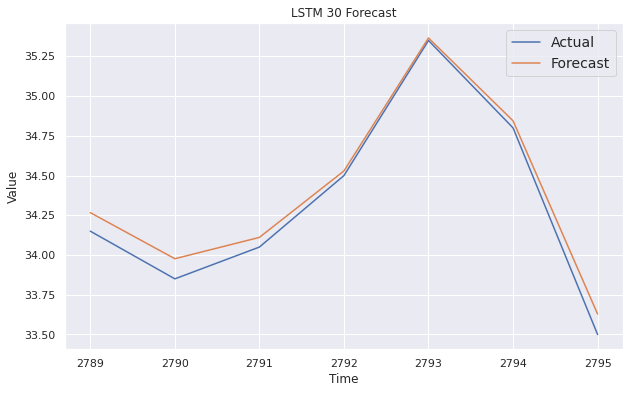

In [ ]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index[:7], x_test[:7], label="Actual")
plot_series(x_test.index[:7], rnn_unscaled_forecast[:7], label="Forecast")
plt.show()

In [ ]:
# calculate MAE
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

1.8516377

## Additional data and training

In [ ]:
! pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf


In [ ]:
ticker = "RELIANCE"
data = yf.download(ticker + '.ns', group_by="ticker", start = '1990-01-01', end = '2022-12-01')

data['Date'] = data.index
data['ticker'] = ticker 

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Date,ticker
Date,,,,,,,,
1996-01-01,15.859429,15.944529,15.754989,15.917452,10.477991,48051995,1996-01-01,RELIANCE
1996-01-02,15.878770,15.956133,15.677626,15.793671,10.396510,77875009,1996-01-02,RELIANCE
1996-01-03,16.052837,16.783918,15.878770,15.913584,10.475446,96602936,1996-01-03,RELIANCE
1996-01-04,15.762726,15.813012,15.553845,15.766594,10.378685,100099436,1996-01-04,RELIANCE
1996-01-05,15.704703,15.704703,15.522900,15.658285,10.307390,76935930,1996-01-05,RELIANCE


In [ ]:
data.to_csv("ticker_RELIANCE.csv", index = False)

In [ ]:
filename = 'ticker_RELIANCE.csv'

In [ ]:
normalized_x_train_2, normalized_x_valid_2, normalized_x_test_2, x_train_scaler_2 , x_test_values_2 = split_data(filename)

In [ ]:

# set window size and create input batch sequence
window_size = 30
train_set_2 = sequential_window_dataset(normalized_x_train_2, window_size)
valid_set_2 = sequential_window_dataset(normalized_x_valid_2, window_size)


In [ ]:
model = keras.models.load_model("my_checkpoint")
model.fit(train_set_2, epochs=500,
          validation_data=valid_set_2,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
157/157 [==============================] - 2s 11ms/step - loss: 6.7188e-05 - mae: 0.0061 - val_loss: 9.9779e-05 - val_mae: 0.0101
Epoch 2/500
157/157 [==============================] - 2s 10ms/step - loss: 6.3045e-05 - mae: 0.0061 - val_loss: 1.0696e-04 - val_mae: 0.0103
Epoch 3/500
157/157 [==============================] - 2s 10ms/step - loss: 6.4038e-05 - mae: 0.0062 - val_loss: 7.7408e-05 - val_mae: 0.0091
Epoch 4/500
157/157 [==============================] - 2s 10ms/step - loss: 5.6544e-05 - mae: 0.0060 - val_loss: 9.3827e-05 - val_mae: 0.0097
Epoch 5/500
157/157 [==============================] - 2s 10ms/step - loss: 6.1998e-05 - mae: 0.0062 - val_loss: 7.1906e-05 - val_mae: 0.0088
Epoch 6/500
157/157 [==============================] - 2s 10ms/step - loss: 5.4919e-05 - mae: 0.0060 - val_loss: 8.9383e-05 - val_mae: 0.0096
Epoch 7/500
157/157 [==============================] - 2s 10ms/step - loss: 6.0301e-05 - mae: 0.0061 - val_loss: 7.3911e-05 - val_mae: 0.0090
Epoch 

157/157 [==============================] - 9s 56ms/step - loss: 7.3164e-05 - mae: 0.0062 - val_loss: 5.2715e-05 - val_mae: 0.0076
Epoch 34/500
157/157 [==============================] - 2s 10ms/step - loss: 4.4306e-05 - mae: 0.0050 - val_loss: 6.3855e-05 - val_mae: 0.0083
Epoch 35/500
157/157 [==============================] - 2s 10ms/step - loss: 4.9492e-05 - mae: 0.0056 - val_loss: 6.8770e-05 - val_mae: 0.0086
Epoch 36/500
157/157 [==============================] - 2s 10ms/step - loss: 5.0133e-05 - mae: 0.0056 - val_loss: 7.4338e-05 - val_mae: 0.0090
Epoch 37/500
157/157 [==============================] - 2s 10ms/step - loss: 5.1564e-05 - mae: 0.0056 - val_loss: 8.1383e-05 - val_mae: 0.0094
Epoch 38/500
157/157 [==============================] - 2s 10ms/step - loss: 5.4027e-05 - mae: 0.0056 - val_loss: 8.7468e-05 - val_mae: 0.0098
Epoch 39/500
157/157 [==============================] - 2s 10ms/step - loss: 5.6901e-05 - mae: 0.0057 - val_loss: 9.1210e-05 - val_mae: 0.0100
Epoch 40/500

In [ ]:
# make predictions
rnn_forecast = model.predict(normalized_x_test_2[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()


1/1 [==============================] - 0s 90ms/step


In [ ]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler_2.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(1354,)

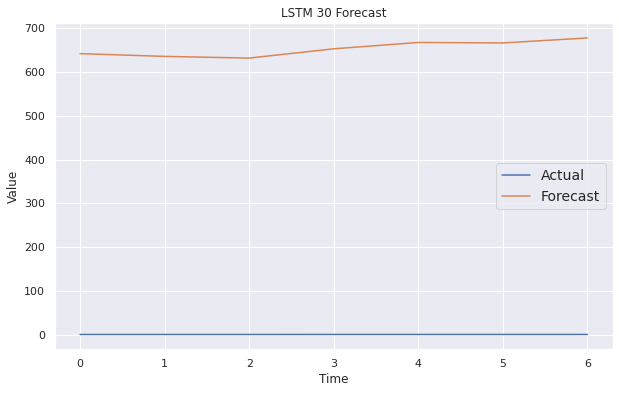

In [ ]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(list(range(7)), normalized_x_test_2[:7], label="Actual")
plot_series(list(range(7)), rnn_unscaled_forecast[:7], label="Forecast")
plt.show()

## Create functions

In [ ]:
ticker = "CRISIL"
data = yf.download(ticker + '.ns', group_by="ticker", start = '1990-01-01', end = '2022-12-01')

data['Date'] = data.index
data['ticker'] = ticker 
data.reset_index(drop=True, inplace=True)



[*********************100%***********************]  1 of 1 completed


In [ ]:
def split_data(filename):
  spy = pd.read_csv(filename)

  # Convert series into datetime type
  spy['Date'] = pd.to_datetime(spy['Date'])

  # Save target series
  series = spy['Close']
    
  # Create train data set
  train_split_date = spy.iloc[int(0.7*len(spy))]['Date']
  train_split_index = np.where(spy.Date == train_split_date)[0][0]
  x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

  # Create test data set
  test_split_date = spy.iloc[int(0.8*len(spy))]['Date']
  test_split_index = np.where(spy.Date == test_split_date)[0][0]
  x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

  # Create valid data set
  valid_split_index = (train_split_index.max(),test_split_index.min())
  x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

  # Reshape values
  x_train_values = x_train.values.reshape(-1, 1)
  x_valid_values = x_valid.values.reshape(-1, 1)
  x_test_values = x_test.values.reshape(-1, 1)

  #  Create Scaler Object
  x_train_scaler = MinMaxScaler(feature_range=(0, 1))

  # Fit x_train values
  normalized_x_train = x_train_scaler.fit_transform(x_train_values)

  # Fit x_valid values
  normalized_x_valid = x_train_scaler.transform(x_valid_values)

  # Fit x_test values
  normalized_x_test = x_train_scaler.transform(x_test_values)

  # All values normalized to training data
  spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))
  return normalized_x_train, normalized_x_valid, normalized_x_test, x_train_scaler, x_test_values

In [ ]:
filename = 'ticker_'+ticker+'.csv'

In [ ]:
normalized_x_train_2, normalized_x_valid_2, normalized_x_test_2, x_train_scaler_2 , x_test_values_2 = split_data(filename)

# set window size and create input batch sequence
window_size = 30
train_set_2 = sequential_window_dataset(normalized_x_train_2, window_size)
valid_set_2 = sequential_window_dataset(normalized_x_valid_2, window_size)

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "ticker_"+ticker+"_checkpoint", save_best_only=True)
model = keras.models.load_model("ticker_"+ticker+"_checkpoint")
model.fit(train_set_2, epochs=500, verbose=10,
          validation_data=valid_set_2,
          callbacks=[early_stopping, model_checkpoint, reset_states])

In [ ]:

# make predictions
rnn_forecast = model.predict(normalized_x_test_2[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()

# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler_2.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

1/1 [==============================] - 1s 634ms/step


(1016,)

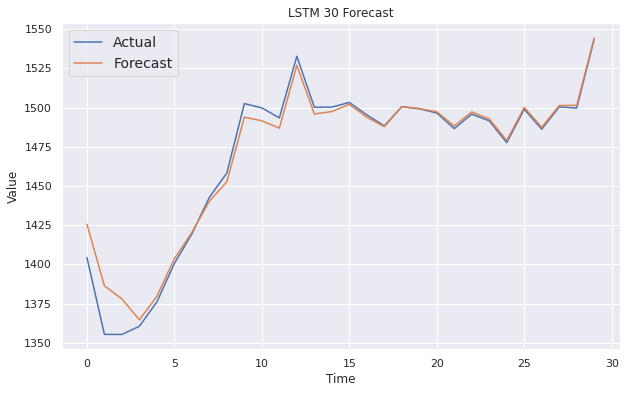

In [ ]:
show_forecast = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(list(range(show_forecast)), x_test_values_2[:show_forecast], label="Actual")
plot_series(list(range(show_forecast)), rnn_unscaled_forecast[:show_forecast], label="Forecast")
plt.show()

In [ ]:
def sequential_window_dataset_dummy(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(2).prefetch(1)

TypeError: ignored

In [ ]:
sequential_window_dataset_dummy(pd.Series(list(range(30))).values.reshape(-1, 1), 7)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None))>

In [ ]:
window_size = 3

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(pd.Series(list(range(20))).values.reshape(-1, 1))
ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
ds = ds.flat_map(lambda window: window.batch(window_size + 1))
ds = ds.map(lambda window: (window[:-1], window[1:]))
d = ds.batch(2).prefetch(1)

In [ ]:
type(d)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
list(d.as_numpy_iterator())

[(array([[[0],
          [1],
          [2]],
  
         [[3],
          [4],
          [5]]]), array([[[1],
          [2],
          [3]],
  
         [[4],
          [5],
          [6]]])), (array([[[ 6],
          [ 7],
          [ 8]],
  
         [[ 9],
          [10],
          [11]]]), array([[[ 7],
          [ 8],
          [ 9]],
  
         [[10],
          [11],
          [12]]])), (array([[[12],
          [13],
          [14]],
  
         [[15],
          [16],
          [17]]]), array([[[13],
          [14],
          [15]],
  
         [[16],
          [17],
          [18]]]))]

In [ ]:

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[2, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-3)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "fake_check", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(d, epochs=3,
          validation_data=d,
          callbacks=[early_stopping, reset_states])

Epoch 1/3
3/3 [==============================] - 3s 374ms/step - loss: 8.6698 - mae: 9.1698 - val_loss: 7.3502 - val_mae: 7.8281
Epoch 2/3
3/3 [==============================] - 0s 23ms/step - loss: 8.1361 - mae: 8.6361 - val_loss: 6.0199 - val_mae: 6.4969
Epoch 3/3
3/3 [==============================] - 0s 22ms/step - loss: 7.4903 - mae: 7.9903 - val_loss: 4.6752 - val_mae: 5.1444


In [ ]:
## TEST successful

In [ ]:
## let's test the model for increased batch size



In [ ]:
def sequential_window_dataset_new(series, window_size, batch_size = 2):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
ticker = "CRISIL"
data = yf.download(ticker + '.ns', group_by="ticker", start = '1990-01-01', end = '2022-12-01')

data['Date'] = data.index
data['ticker'] = ticker 
data.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
page = pd.read_html("https://en.wikipedia.org/wiki/List_of_companies_listed_on_the_National_Stock_Exchange_of_India")
type(page[1])

pandas.core.frame.DataFrame

In [ ]:
df = pd.DataFrame()
for p in page:
  #print(p)
  #user_input = input("y/n")
  if "Symbol" in p.columns:
    df = pd.concat([df,p], axis = 0)
    print(df.shape)

(8, 2)
(177, 2)
(277, 2)
(368, 2)
(432, 2)
(482, 2)
(506, 2)
(614, 2)
(678, 2)
(766, 2)
(824, 2)
(892, 2)
(930, 2)
(1056, 2)
(1118, 2)
(1157, 2)
(1257, 2)
(1259, 2)
(1333, 2)
(1557, 2)
(1680, 2)
(1713, 2)
(1767, 2)
(1789, 2)
(1792, 2)
(1793, 2)
(1808, 2)


In [ ]:
def get_sym(symbol):
  return str(symbol).split()[-1]

df['stock_sym'] = df['Symbol'].apply(get_sym)

In [ ]:
df = df.reset_index(drop=True)


In [ ]:
for ticker in df['stock_sym'].to_list():
    try:
      data = yf.download(ticker + '.ns', group_by="ticker", start = '1990-01-01', end = '2022-12-01')
      if len(data) < 600:
        print(ticker)
        continue
      data['Date'] = data.index
      data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
      data.to_csv(f'ticker_{ticker}.csv', index = False)  #
    except:
      print(ticker)

## create classes


In [7]:
! pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [56]:

class StockData():
  def __init__(self, ticker, window_size = 30, batch_size = 2):
    self.ticker = ticker
    self.window_size = window_size
    self.batch_size = batch_size
  def sequential_window_dataset(self, series):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(self.window_size + 1, shift=self.window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(self.window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(self.batch_size).prefetch(1)

  def prepareData(self):
    ticker = self.ticker
    data = yf.download(ticker + '.ns', group_by="ticker", start = '1990-01-01', end = '2022-12-01')

    data['Date'] = data.index
    data['ticker'] = ticker 
    data.reset_index(drop=True, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    # Save target series
    series = data['Close']
      
    # Create train data set
    train_split_date = data.iloc[int(0.7*len(data))]['Date']
    train_split_index = np.where(data.Date == train_split_date)[0][0]
    x_train = data.loc[data['Date'] <= train_split_date]['Close']

    # Create test data set
    test_split_date = data.iloc[int(0.8*len(data))]['Date']
    test_split_index = np.where(data.Date == test_split_date)[0][0]
    self.x_test = data.loc[data['Date'] >= test_split_date]['Close']

    # Create valid data set
    valid_split_index = (train_split_index.max(),test_split_index.min())
    x_valid = data.loc[(data['Date'] < test_split_date) & (data['Date'] > train_split_date)]['Close']

    # Reshape values
    x_train_values = x_train.values.reshape(-1, 1)
    x_valid_values = x_valid.values.reshape(-1, 1)
    self.x_test_values = self.x_test.values.reshape(-1, 1)

    #  Create Scaler Object
    self.x_train_scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit x_train values
    self.normalized_x_train = self.x_train_scaler.fit_transform(x_train_values)

    # Fit x_valid values
    self.normalized_x_valid = self.x_train_scaler.transform(x_valid_values)

    # Fit x_test values
    self.normalized_x_test = self.x_train_scaler.transform(self.x_test_values)

    # All values normalized to training data
    #data_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))
  def get_training_set(self):
    self.train_set =  self.sequential_window_dataset(self.normalized_x_train)
    return self.train_set
  def get_validation_set(self):
    self.validation_set =  self.sequential_window_dataset(self.normalized_x_valid)
    return self.validation_set
  def get_testing_set(self):
    return self.normalized_x_test[np.newaxis,:]

  def get_numpy_train_data(self):
    return list(self.train_set.as_numpy_iterator())

  def plot_series(self, time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [33]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [63]:
class StockModel():
  def __init__(self, lstm_nodes = [100, 100] , first_model = False, prev_ticker = "", ticker = "", window_size = 30, batch_size = 2):
    if first_model:
      self.lstm_nodes = lstm_nodes
      self.prev_ticker = prev_ticker
      self.ticker = ticker
      self.batch_size = batch_size
      self.window_size = window_size
      model_list = []
      model_list.append(keras.layers.LSTM(self.lstm_nodes[0], return_sequences=True, stateful=True,
                              batch_input_shape=[self.batch_size, None, 1]))
      for nodes in lstm_nodes[1:]:
        model_list.append(keras.layers.LSTM(nodes, return_sequences=True, stateful=True))
        
      
      model_list.append(keras.layers.Dense(1))
      self.model = keras.models.Sequential(model_list)
      
      # set optimizer
      optimizer = keras.optimizers.Nadam(lr=1e-3)

      # compile model
      self.model.compile(loss=keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
    else:
      self.model = keras.models.load_model("ticker_"+self.prev_ticker+"_checkpoint_"+str(self.window_size)+"_BS_"+str(self.batch_size))

    self.Stockdata = StockData(self.ticker,self.window_size, self.batch_size)

     
  def prepare_data(self):
    self.Stockdata.prepareData( )
    self.training_set = self.Stockdata.get_training_set()
    self.validation_set = self.Stockdata.get_validation_set()
    self.test_set = self.Stockdata.get_testing_set()

  def train(self, epochs, patience):
    
    # reset states
    reset_states = ResetStatesCallback()

    #set up save best only checkpoint
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        "ticker_"+self.ticker+"_checkpoint_"+str(self.window_size)+"_BS_"+str(self.batch_size), save_best_only=True)

    early_stopping = keras.callbacks.EarlyStopping(patience=patience)

    # fit model
    self.model.fit(self.training_set, epochs=epochs,
              validation_data=self.validation_set,
              callbacks=[early_stopping, model_checkpoint ,reset_states])
    print("Training finished")

  def evaluate(self):
    # make predictions
    rnn_forecast = self.model.predict(self.test_set)
    self.Stockdata.rnn_forecast = rnn_forecast.flatten()
    self.Stockdata.rnn_unscaled_forecast = self.Stockdata.x_train_scaler.inverse_transform(self.Stockdata.rnn_forecast.reshape(-1,1)).flatten()

  def show_result(self,start_win_size, offset):
    # plot results
    plt.figure(figsize=(10,6))

    plt.ylabel('Rupees ')
    plt.xlabel('Timestep in Days')
    plt.title(f'LSTM { start_win_size } Forecast')
    self.Stockdata.plot_series(self.Stockdata.x_test.index[start_win_size:start_win_size + offset], self.Stockdata.x_test[start_win_size:start_win_size + offset], label="Actual")
    self.Stockdata.plot_series(self.Stockdata.x_test.index[start_win_size:start_win_size + offset], self.Stockdata.rnn_unscaled_forecast[start_win_size :start_win_size + offset], label="Forecast")
    plt.show()
  def load_current_model(self):
    self.model = keras.models.load_model("ticker_"+self.ticker+"_checkpoint_"+str(self.window_size)+"_BS_"+str(self.batch_size))

  def show_train_data(self):
    return self.Stockdata.get_numpy_train_data()


In [44]:
reliance_stock_model = StockModel(lstm_nodes = [100, 100] , first_model = True, prev_ticker = "", ticker = "RELIANCE", window_size = 30, batch_size = 1)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [45]:
reliance_stock_model.prepare_data()
d = reliance_stock_model.show_train_data()

[*********************100%***********************]  1 of 1 completed


In [46]:
d[0][0].shape

(1, 30, 1)

In [ ]:
reliance_stock_model.train(100,20) 

In [64]:
reliance_stock_model = StockModel(lstm_nodes = [100, 100] , first_model = True, prev_ticker = "", ticker = "RELIANCE", window_size = 30, batch_size = 1)
reliance_stock_model.load_current_model()
reliance_stock_model.prepare_data()
reliance_stock_model.evaluate()


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 1s 838ms/step


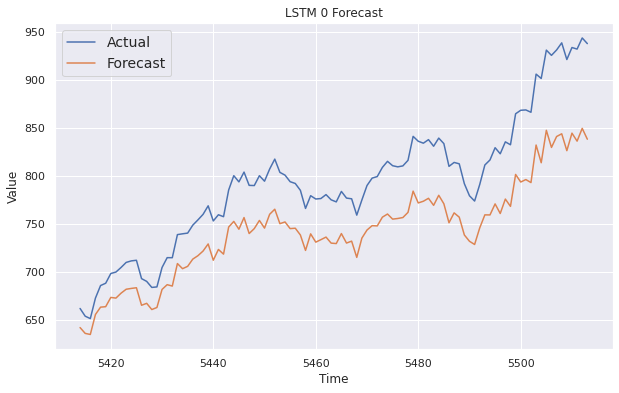

In [67]:
reliance_stock_model.show_result(0,100)